In [65]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns


In [66]:
class momentumBackTester():
    def __init__(self, asset_name, start, end, transaction_cost = 0, price_col = 'Adj Close'):
        self.asset_name = asset_name
        self.start = start
        self.end = end
        self.price_col = price_col
        self.data = self.data_processor(pd.read_csv(self.asset_name+'.csv', index_col = 0, parse_dates = True).dropna())
        #self.data= yf.download(asset_name, start=start)
        self.marketReturn = self.data.tail(1).values[0] / self.data.head(1).values[0]
        # print("Market Return For" +  asset_name + " is " + str(self.marketReturn[0] * 100) + "%")
        # return initialization
        self.data['returns'] = np.log(self.data['price']/self.data['price'].shift(1))              # if p[T + 1] > p[T], return for T > 0
    
        
    def data_processor(self,raw):
        price_col = self.price_col
        data = pd.DataFrame(raw[price_col])
        data.rename(columns = {price_col: 'price'}, inplace = True)
        
        # date mask
        mask = (data.index > self.start) & (data.index <= self.end)
        data = data.loc[mask]
        return data
    
    def single_test(self,window,plot = True):
        data = self.data
        rollingWindow = window

        data['position'] = np.sign(data['returns'].rolling(rollingWindow).mean())   # if mean of return during rolling window > 0, 
                                                                                    # position has positive sign ( = 1.0)

        data['strat'] = data['position'].shift(1) * data['returns']                 # strat = sign * return 
        
        df = data[['returns', 'strat']].dropna().cumsum().apply(np.exp)
        return_strategy = df.tail(1).values[0][1]
        print("Return for strategy (window = %d): %s" %(window, format(return_strategy* 100 - 100, ".2f")) +"%")
        
        if plot:
            df.plot(title = self.asset_name + ' Return and Strategy Return, rolling window = ' + str(window), figsize=(10, 6))
        
    def multiple_test(self, min, max, step,plot = True):
        data = self.data
        plot_col = ['returns']

        strat_cnt = 0
        line_style = ['-']
        for w in range(min,max,step):
            data['position_%d' % w] = np.sign(data['returns'].rolling(w).mean())   
            data['strat_%d' % w] = data['position_%d' % w].shift(1) * data['returns']                 # strat = sign * return          
            plot_col.append('strat_%d' % w)
            strat_cnt += 1
            line_style.append('--')
        
        df = data[plot_col].dropna().cumsum().apply(np.exp)
        
        #print function
        for w in range(min,max,step):
            return_strategy = df['strat_%d' % w].tail(1).values[0]
            print("Return for strategy (window = %d): %s" %(w,format(return_strategy* 100 - 100, ".2f") ) + "%")
            
        if plot:
            df.plot(title = 'TSLA Return and Strategies Comparison', 
                                                                        figsize=(16, 9), style = line_style)
        
        
    def getSharpeRatio(self):
        data = self.data
        std=  data['returns'].std()
        

    def drawHeatMap(self, windowMax, windowMin = 1):
        data = self.data      
        plot_col = ['returns']
        new_columns_position = {}
        new_columns_strat = {}
        for w in range(windowMin,windowMax):
            new_columns_position['position_%d' %w] =  np.sign(data['returns'].rolling(w).mean())   

        new_columns_position= pd.DataFrame(new_columns_position, index = data.index)
        data = pd.concat([data,new_columns_position],axis = 1)
   
        for w in range(windowMin,windowMax):
            new_columns_strat['strat_%d' % w] = data['position_%d' % w].shift(1) * data['returns']                 # strat = sign * return          
            plot_col.append('strat_%d' % w)
        
        new_columns_strat = pd.DataFrame(new_columns_strat, index = data.index)
        data = pd.concat([data,new_columns_strat],axis = 1)
        
        df = data[plot_col].dropna().cumsum().apply(np.exp)
        
        returns = []
        std = []
        returns_daily_mean = []
        
        for w in range(windowMin,windowMax):
            #windows.append(w)
            std.append(df['strat_%d' % w].std())
            returns.append(df['strat_%d' % w].tail(1).values[0] - 1)
            returns_daily_mean.append(data['strat_%d' % w].mean())
        
        '''
        annualizing attempt to calculate SR, however result seems incorrect
        '''
        SR_daily = []
        SR_annualized = []
        for i in range(0,len(std)):
            SR_daily.append(returns_daily_mean[i] / std[i])
            SR_annualized.append(SR_daily[i]*252**.5)    
        
        '''
        SR #2
        '''
        
        SR = []
        for i in range(0,len(std)):
            SR.append(returns[i] / std[i])
        
        # RETURN HEATMAP
        plt.figure(dpi = 1200)
        dt = {'Return %':returns}
        df_hm =pd.DataFrame(dt)
        df_hm *= 100 # PERCENTAGE
        ax = sns.heatmap(df_hm).set_title("Heatmap: return% for strategy on "+ self.asset_name + " vs windows lengths \n "+self.start + " ~ " + self.end)
        plt.savefig('returnsVSwindows.pdf')
        plt.show()
        
        #SHARPE RATIO HEATMAP (ANNUALIZED ATTEMPT)
        plt.figure(dpi=1200)
        dt_sr_annualized = {'Sharpe Ratio Annualized' : SR_annualized}
        df_hm_sr_annualized =pd.DataFrame(dt_sr_annualized)
        ax = sns.heatmap(df_hm_sr_annualized).set_title("Heatmap: Annualized Sharpe Ratio for strategy on "+ self.asset_name + " vs windows lengths \n "+self.start + " ~ " + self.end)
        plt.savefig('SR_annualizedVSwindows.pdf')
        plt.show()
        
        #SHARPE RATIO 
        plt.figure(dpi=1200)
        dt_sr = {'Sharpe Ratio' : SR}
        df_hm_sr =pd.DataFrame(dt_sr)
        ax = sns.heatmap(df_hm_sr).set_title("Heatmap: Sharpe Ratio for strategy on "+ self.asset_name + " vs windows lengths \n "+self.start + " ~ " + self.end)
        plt.savefig('SRVSwindows.pdf')
        plt.show()
        
        
        '''
        vec = np.asarray(returns)
        fig, ax = plt.subplots()
        tr = transforms.Affine2D().rotate_deg(90)
        vec2 = vec.reshape(vec.shape[0], 1)
        sns.heatmap(vec2,annot=True, fmt="f",xticklabels=False,yticklabels = step)
        plt.show(tr)
        '''
        

In [67]:
# initialization: input parameter: name(.csv), startDate, endDate.
engine = momentumBackTester('TSLA', '6/15/2017' , '6/15/2022')

Market Return ForTSLA is 941.0339383553303%


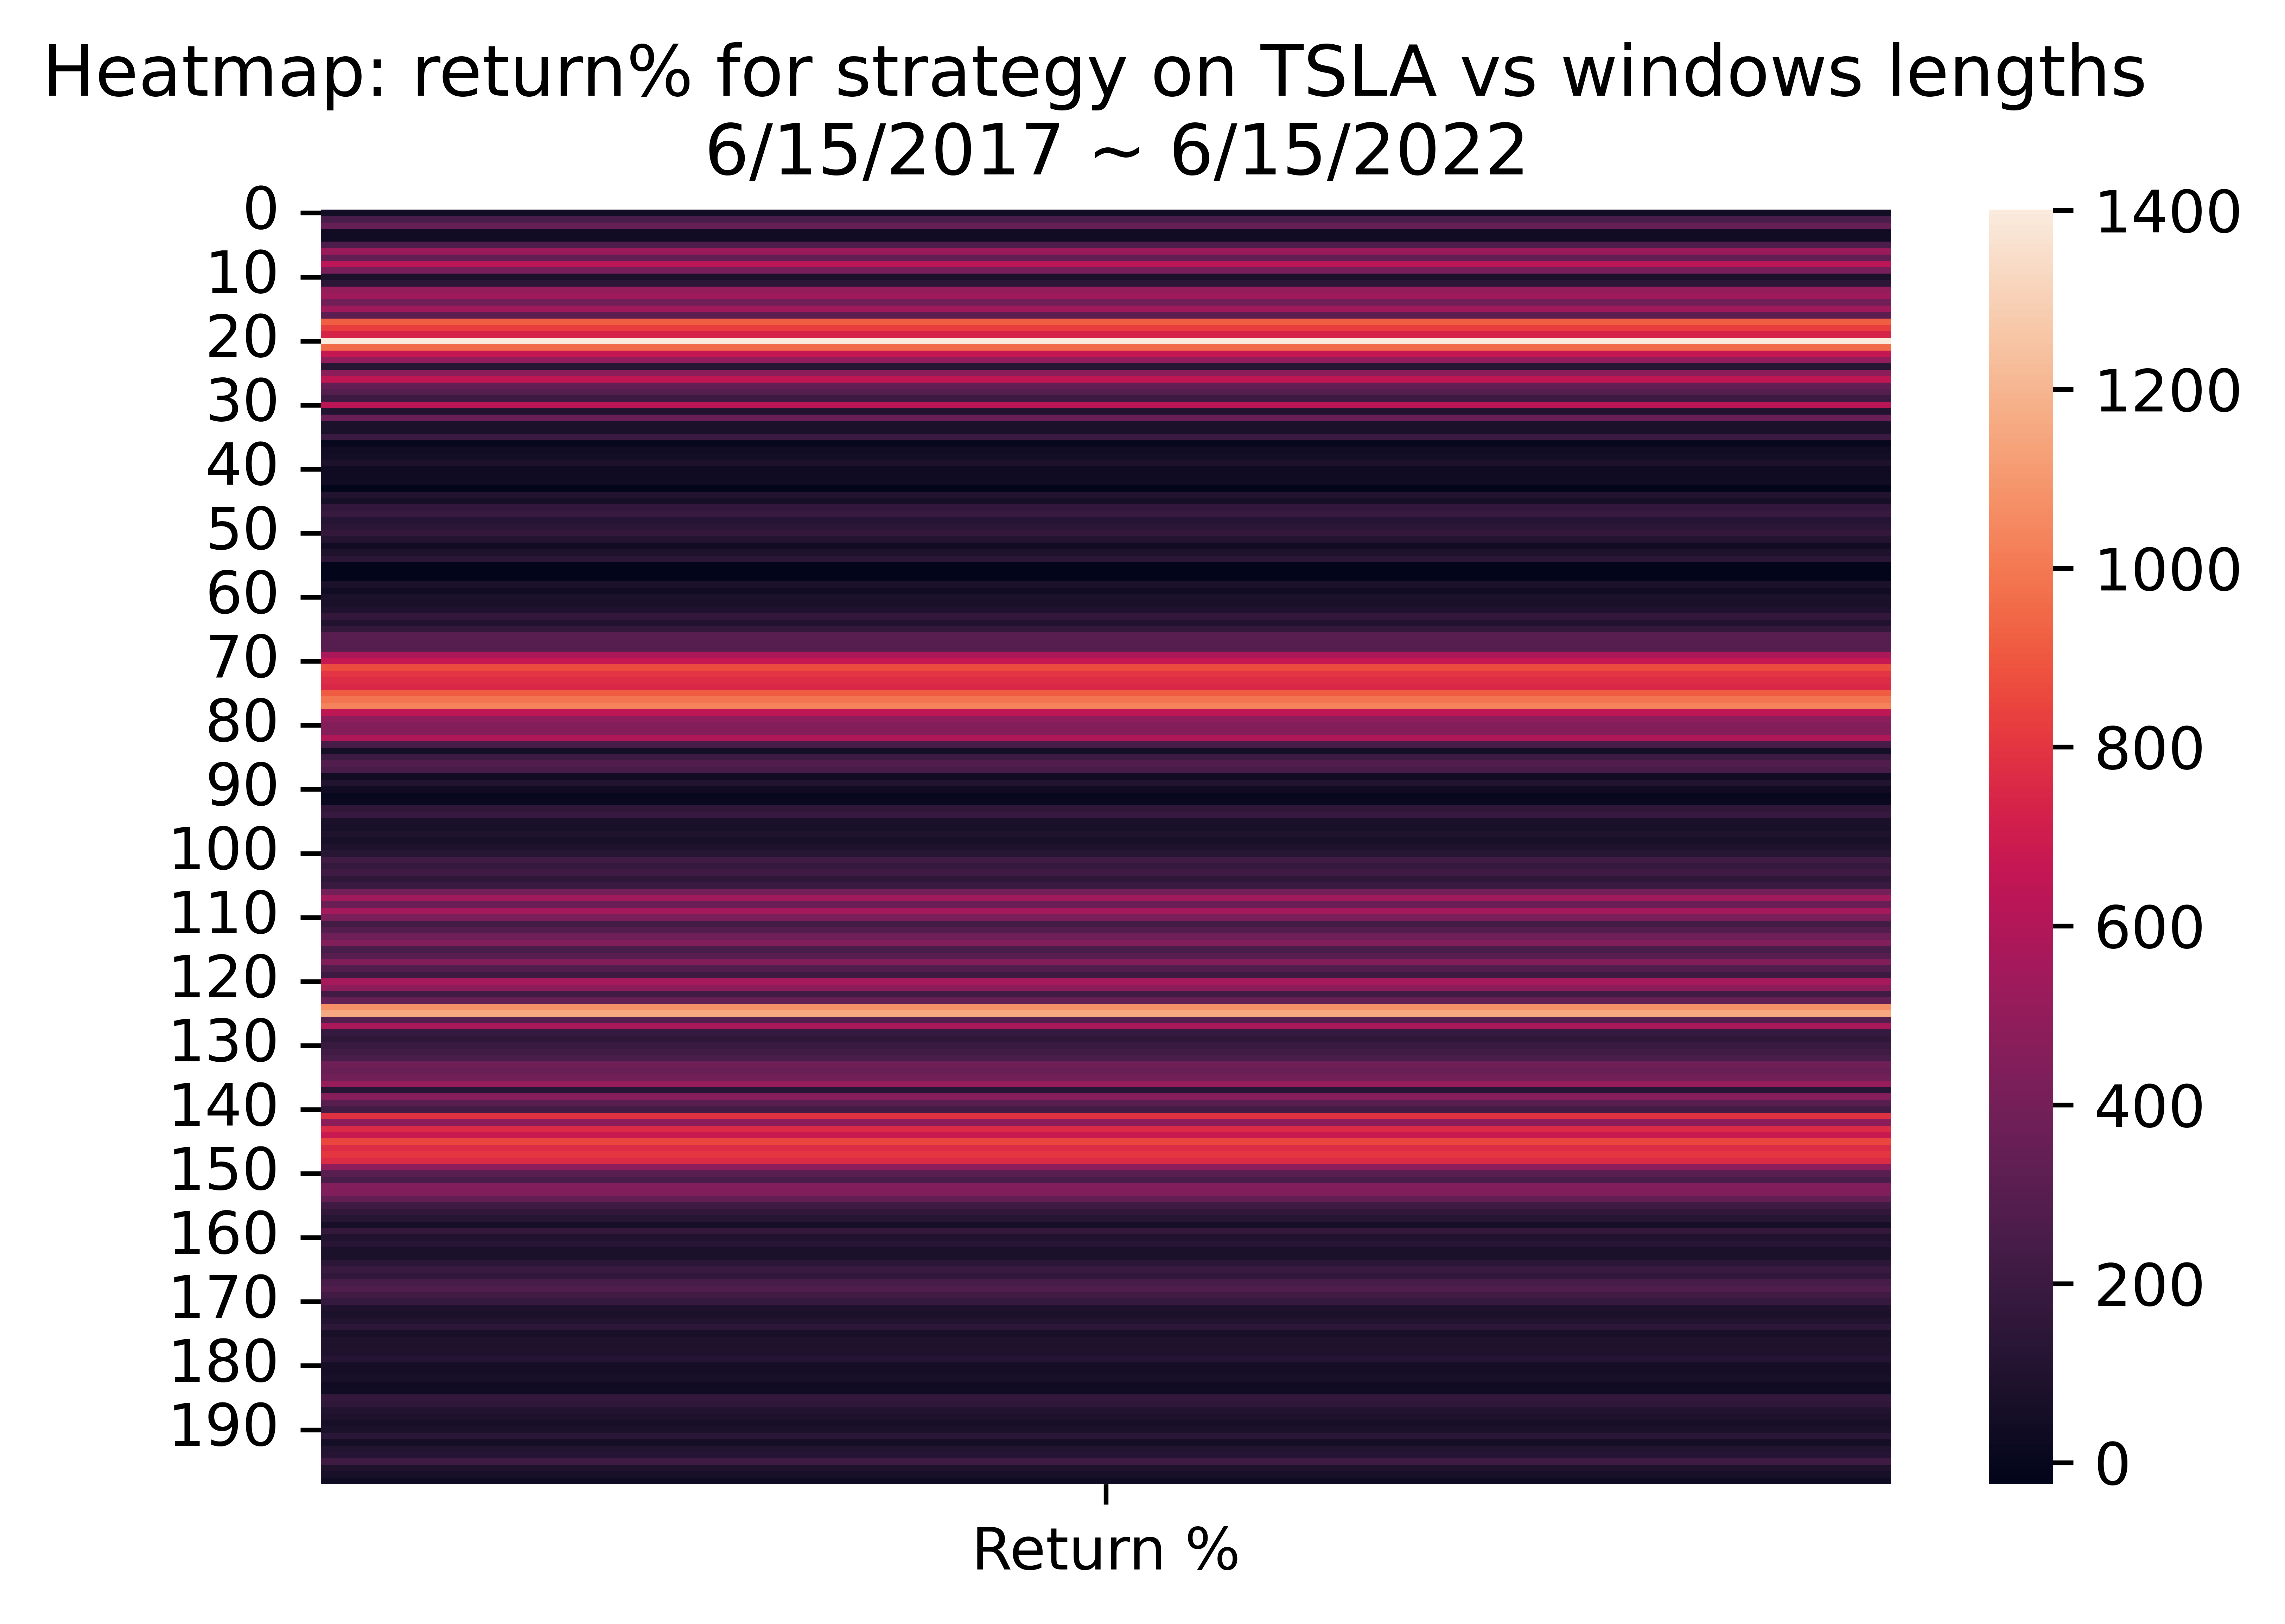

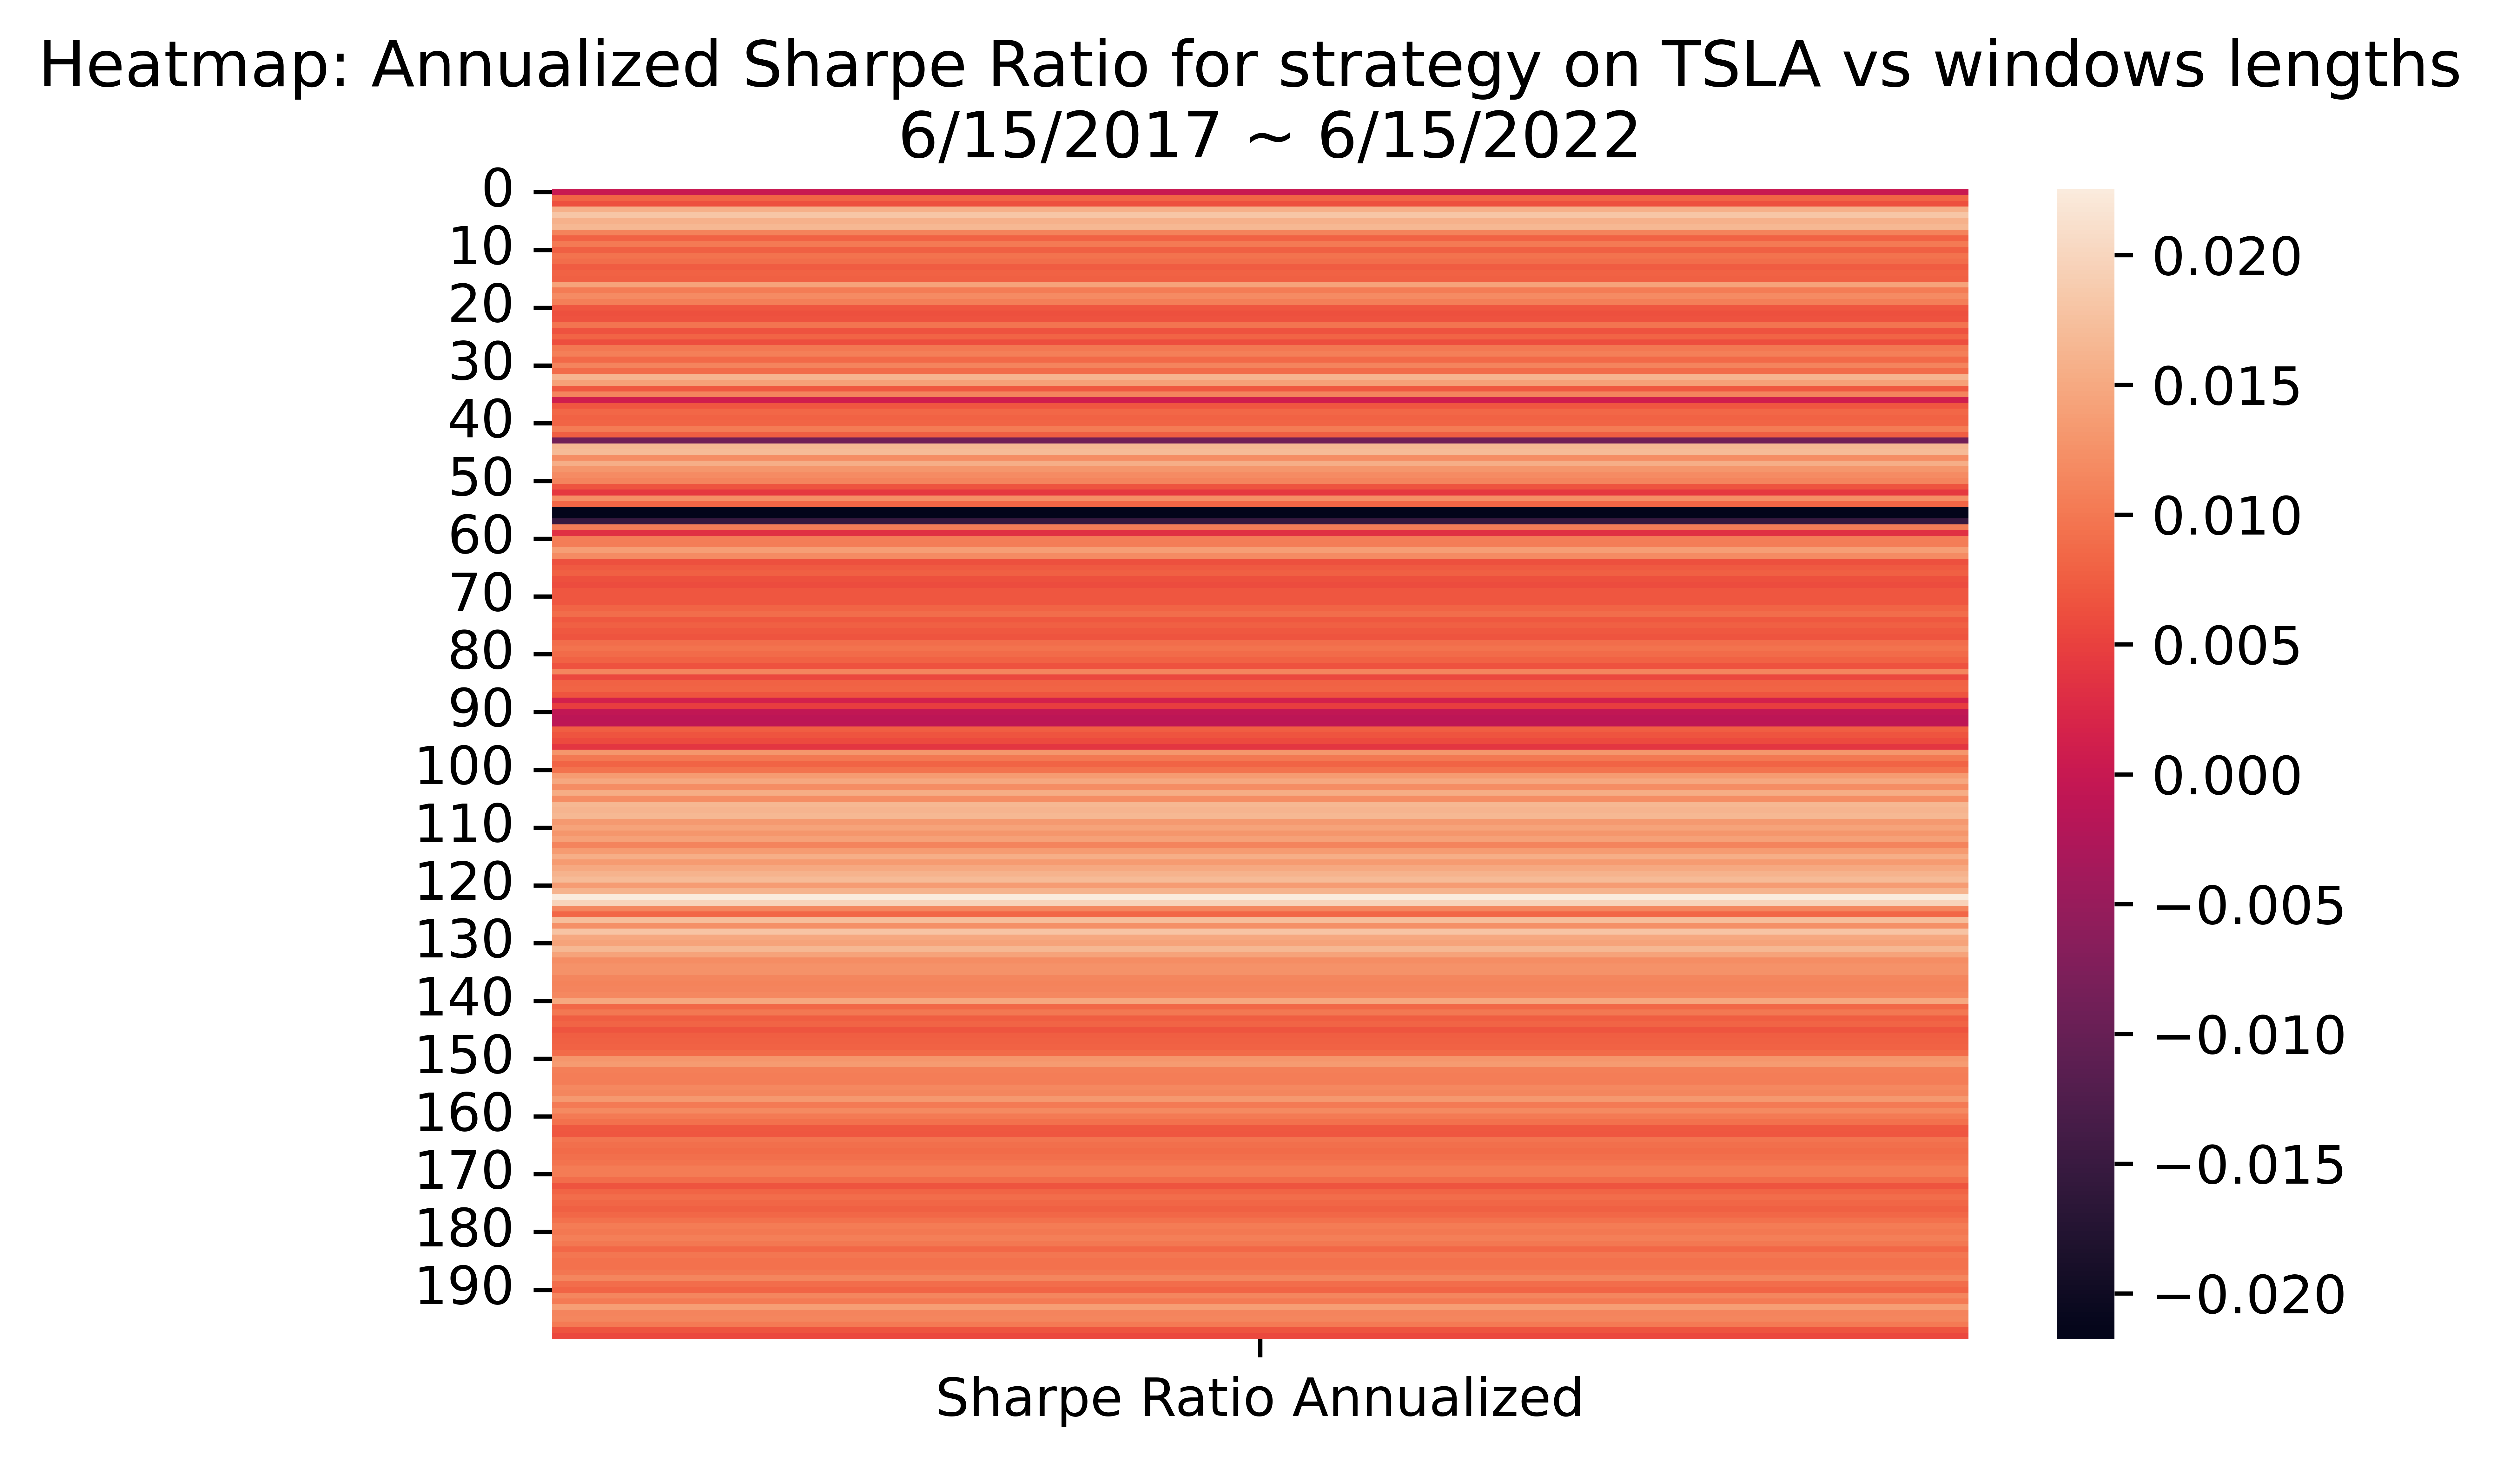

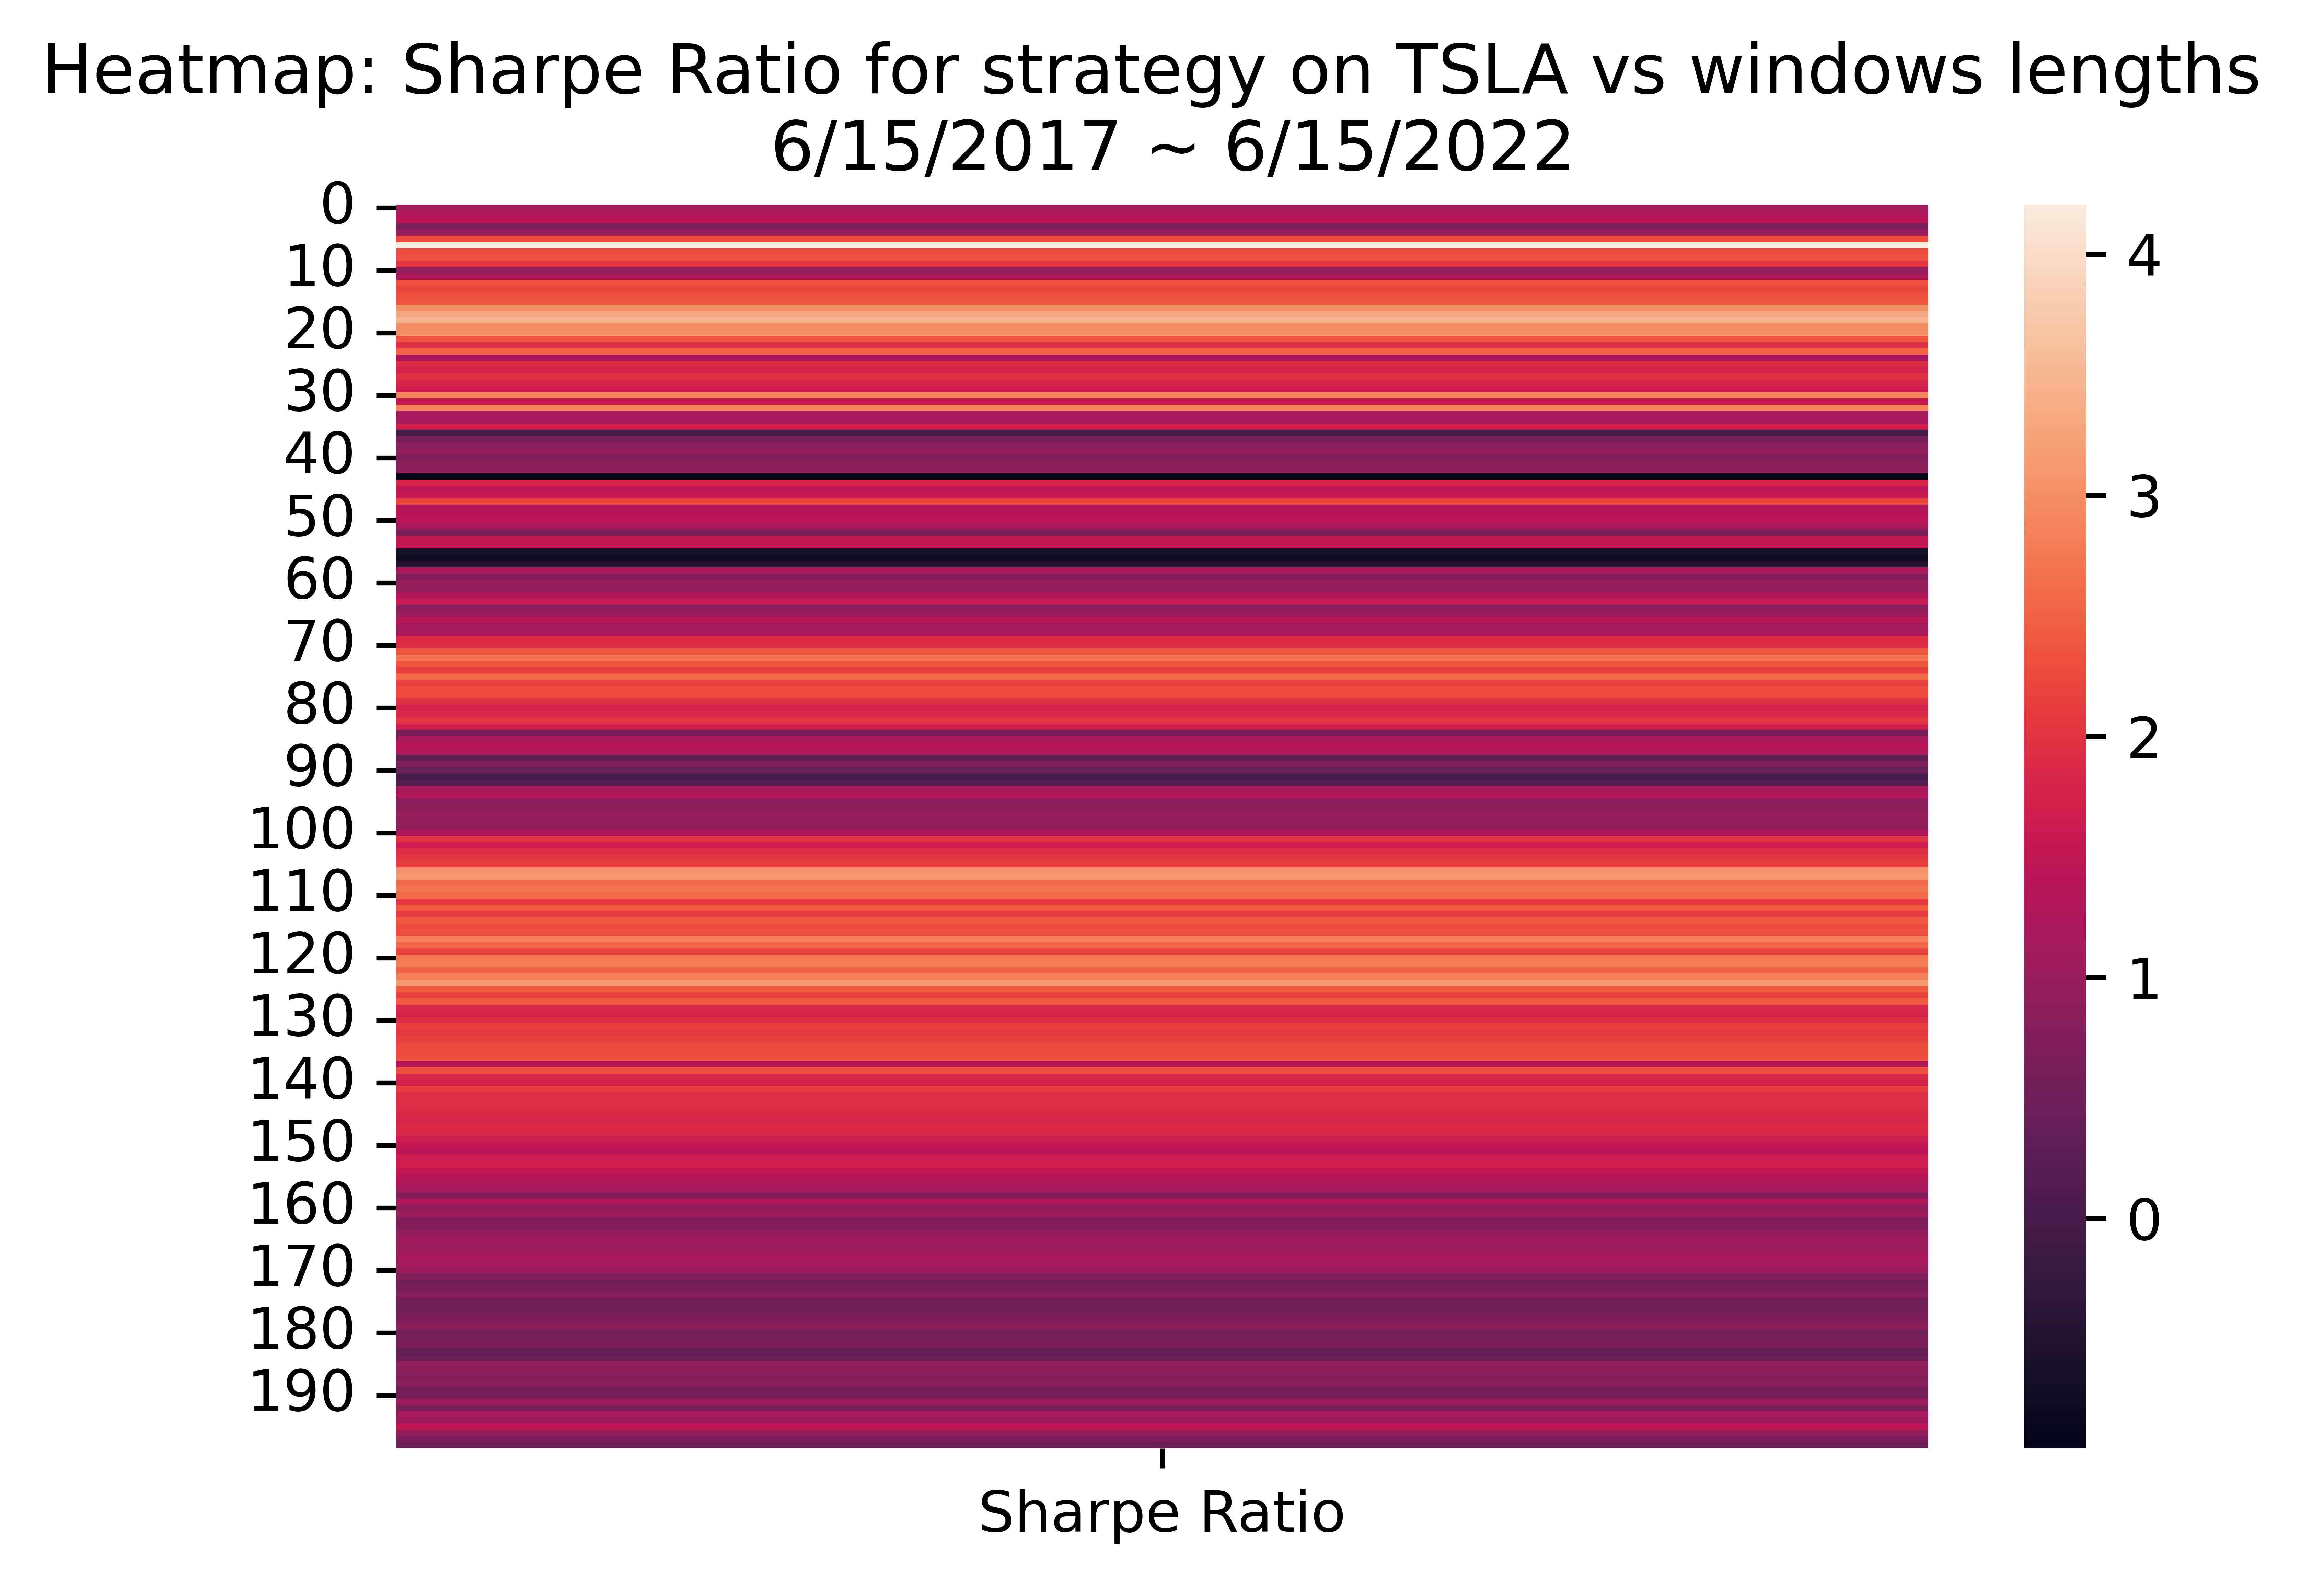

In [68]:
engine.drawHeatMap(200)

Return for strategy (window = 1): 0.68%
Return for strategy (window = 3): 246.14%


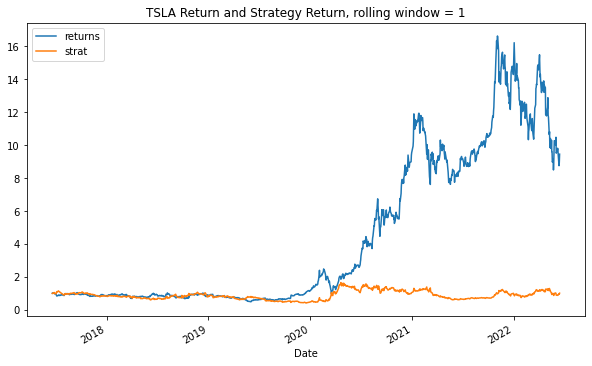

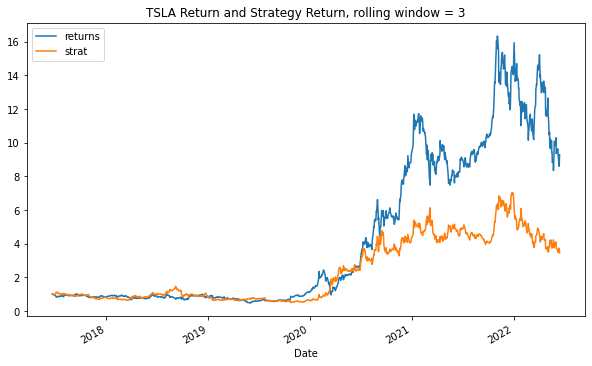

In [69]:
# test a single rolling window, e.g 1 day, 3 day mean
engine.single_test(1)
engine.single_test(3)

Return for strategy (window = 1): 1.74%
Return for strategy (window = 11): 107.25%
Return for strategy (window = 21): 1374.38%
Return for strategy (window = 31): 786.60%
Return for strategy (window = 41): 32.92%
Return for strategy (window = 51): 173.08%
Return for strategy (window = 61): 83.78%
Return for strategy (window = 71): 581.21%
Return for strategy (window = 81): 373.34%
Return for strategy (window = 91): -4.30%


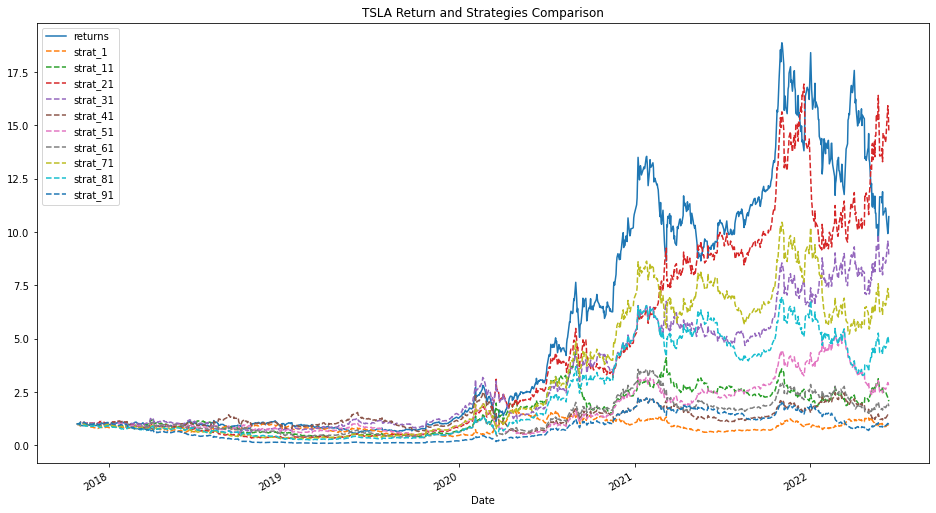

In [70]:
# test multiple rolling window at the same time. Input: min, max, step (as in python range function)
engine.multiple_test(1,100,10)